In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

In [2]:
path = "scan_x256_y256.raw"
#frame size of the EMPAD detector
frame_size = (128,128)
#numbers of scanning positions along fast and slow direction.
scan_size = (256,256)
# bitdepth - this will depend on dynamic range used by MerlinEM detector
bit_depth = np.float32
#map the memory
EMPAD_frame_dtype = np.dtype([('data', bit_depth, frame_size),('tail', bit_depth, 256)])
# map the file to memory
data = np.memmap(path, EMPAD_frame_dtype, shape=scan_size, mode='r')

In [3]:
dat4d = data['data']

C:\Users\sning\AppData\Local\Temp/ipykernel_16852/3526536063.py:10: RuntimeWarning: invalid value encountered in log10
  im=grid[0].imshow(np.log10(pacbed+1), cmap=plt.cm.viridis)


Text(0.5, 1.0, 'position averaged CBED')

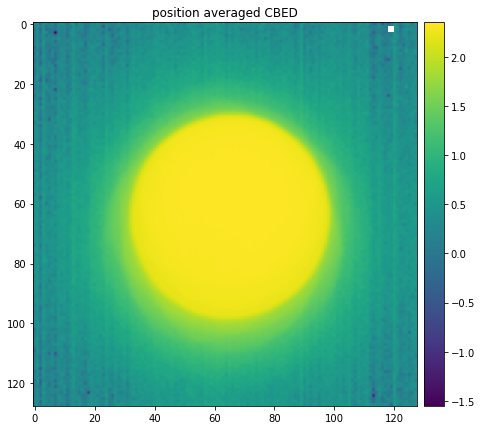

In [4]:
pacbed = np.average(dat4d, axis=(0,1))
fig =plt.figure(1, figsize=(25, 25))
grid=AxesGrid(fig, 236, nrows_ncols=(1,1),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(np.log10(pacbed+1), cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")

Text(0.5, 1.0, 'Masked PACBED')

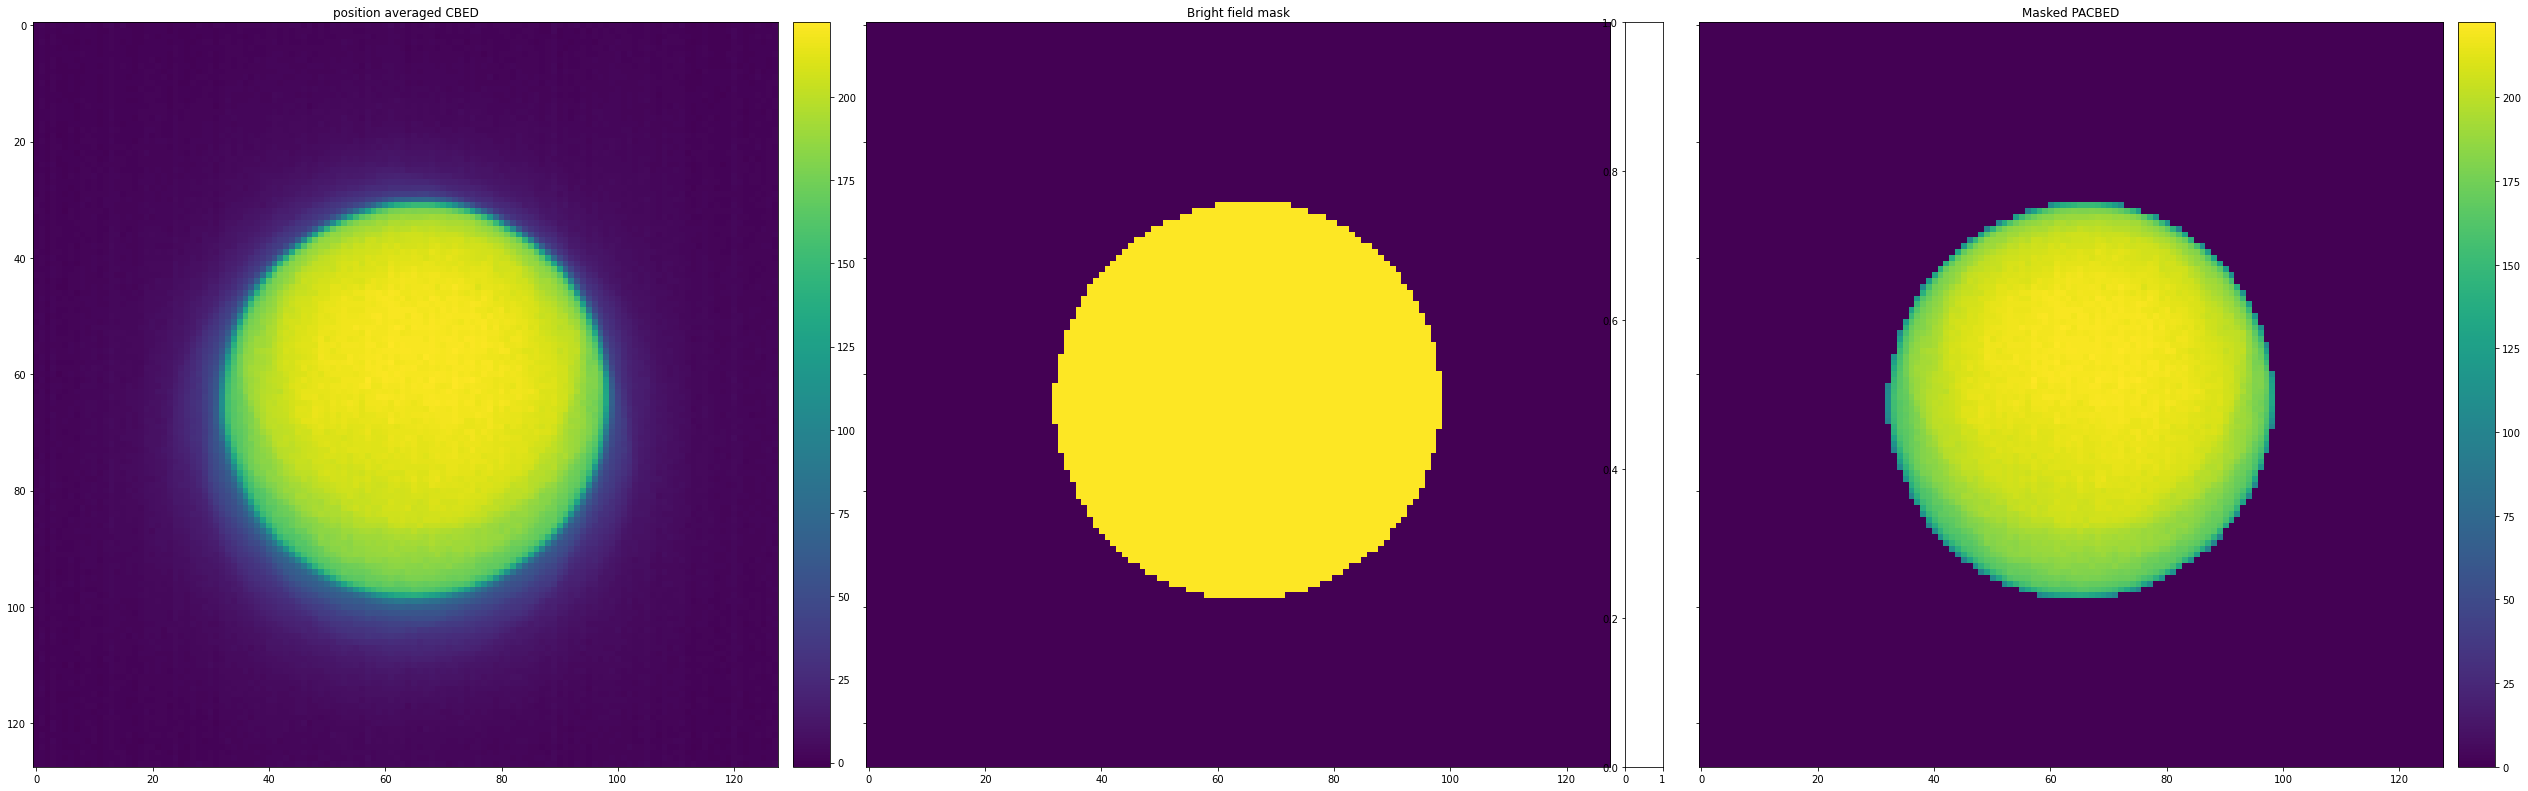

In [5]:
thresh = np.average(pacbed)*2.0
BFdisk = pacbed > thresh
mpacbed = pacbed * BFdisk
#get the mask of aperture via threshold values.
fig =plt.figure(1, figsize=(150, 50))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(pacbed, cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("position averaged CBED")
im=grid[1].imshow(BFdisk, cmap=plt.cm.viridis)
grid[1].set_title("Bright field mask")
im=grid[2].imshow(mpacbed, cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Masked PACBED")

In [6]:
#compute the center of aperture according to determined mask image. 
X, Y = np.meshgrid(np.arange(0, pacbed.shape[1]), np.arange(0, pacbed.shape[0]))
x_center, y_center =np.average(mpacbed * X), np.average(mpacbed * Y)
x_center/=np.average(mpacbed)
y_center/=np.average(mpacbed)
#get the edge of bright field apertuer and fit the radius in pixels. 
grad=np.sqrt(np.sum(np.square(np.abs(np.gradient(pacbed))), axis =0))
edge = grad > np.max(grad)*0.5
radius = np.average(np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2)[edge])
#get the half of the aperture to compute ABF
ADFdisk = (np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2))>radius*1.1
InnerBFdisk = (np.sqrt((X - x_center) ** 2 + (Y - y_center) ** 2))<(radius/2)
BFImage=[]
ADFImage=[]
InnerBFImage=[]
for ycan in range(np.shape(dat4d)[0]):
    for xcan in range(np.shape(dat4d)[1]):
        BFImage.append(np.sum(dat4d[ycan,xcan,:,:]*BFdisk))
        ADFImage.append(np.sum(dat4d[ycan,xcan,:,:]*ADFdisk))
        InnerBFImage.append(np.sum(dat4d[ycan,xcan,:,:]*InnerBFdisk))
BFImage = np.reshape(np.asarray(BFImage), (np.shape(dat4d)[0], np.shape(dat4d)[1]))
ADFImage = np.reshape(np.asarray(ADFImage), (np.shape(dat4d)[0], np.shape(dat4d)[1]))
InnerBFImage = np.reshape(np.asarray(InnerBFImage), (np.shape(dat4d)[0], np.shape(dat4d)[1]))
ABFImage = BFImage - InnerBFImage

Text(0.5, 1.0, 'Annular Dark Field Image')

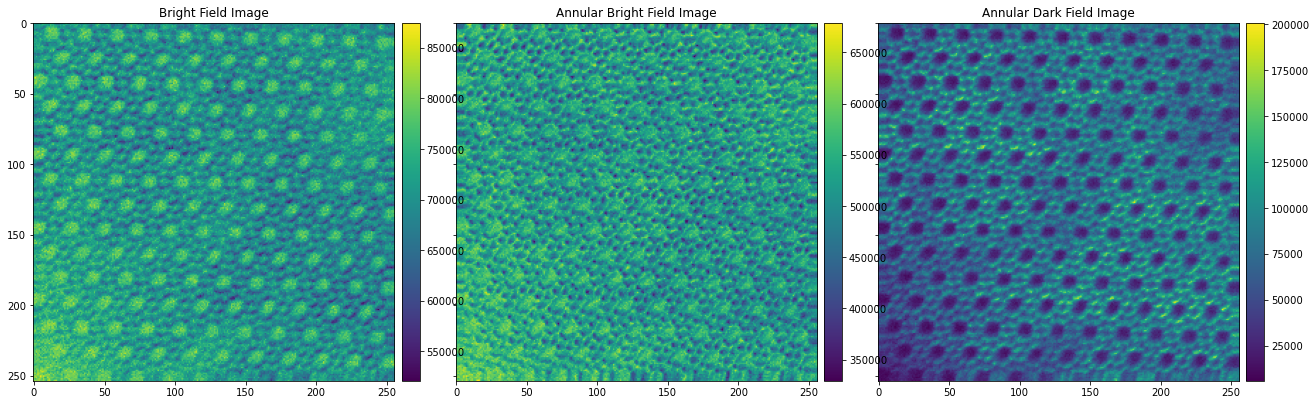

In [9]:
fig =plt.figure(1, figsize=(75, 25))
grid=AxesGrid(fig, 236, nrows_ncols=(1,3),
             axes_pad=0.5,
             share_all=False,
             cbar_location="right",
             cbar_mode="each",
             cbar_size="5%",
             cbar_pad="2%")
im=grid[0].imshow(BFImage[2:], cmap=plt.cm.viridis)
grid.cbar_axes[0].colorbar(im)
grid[0].set_title("Bright Field Image")
im=grid[1].imshow(ABFImage[2:], cmap=plt.cm.viridis)
grid.cbar_axes[1].colorbar(im)
grid[1].set_title("Annular Bright Field Image")
im=grid[2].imshow(ADFImage[2:], cmap=plt.cm.viridis)
grid.cbar_axes[2].colorbar(im)
grid[2].set_title("Annular Dark Field Image")

In [10]:
np.save("data.npy", dat4d[2:])